# Import necessary libraries

General guideline:

This notebook is a bert implementation of classification of human and machine translation from Chinese to English. 
It achieves classification macro F-1 score of 0.878 on the test set. To validate the results, run all the cells below.

In [260]:
#import necessary libraries
import torch
import numpy as np
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [41]:
#import bert
from transformers import AutoTokenizer
from transformers import AutoModel
chinese_tokenizer = AutoTokenizer.from_pretrained('bert-base-chinese')
chinese_bert = AutoModel.from_pretrained("bert-base-chinese")
english_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
english_bert = AutoModel.from_pretrained("bert-base-uncased")

# Definition of a class of data unit

In [69]:
#the class of a pair of sentences
#human is 0 and machine is 1
class Data_unit:
    #initialize the data_unit with some input of raw lines
    def __init__(self, raw_lines):
        #-1 is used to remove the last \n
        #we replace the empty space between chinese characters
        self.chinese = raw_lines[0][:-1].replace(' ','')
        self.gold = raw_lines[1][:-1]
        self.another = raw_lines[2][:-1]
        self.score = float(raw_lines[3][:-1])
        if raw_lines[4] == 'H\n' :
            self.label = 0
        elif raw_lines[4] == 'M\n':
            self.label = 1
        #if something is wrong rasie an error
        else:
            raise RuntimeError('Formatting problem of the input file')
    #init bert embeddings for the data unit
    def init_bert_embeddings(self, chinese_tokenizer, chinese_bert, english_tokenizer, english_bert):
        self.chinese_embeddings = bert_embeddings(self.chinese, chinese_tokenizer, chinese_bert)
        self.gold_embeddings = bert_embeddings(self.gold, english_tokenizer, english_bert)
        self.another_embeddings = bert_embeddings(self.another, english_tokenizer, english_bert)
    #return the feature to be trained 
    def get_feature(self):
        return np.concatenate((self.chinese_embeddings, self.gold_embeddings, self.another_embeddings))
        

# Preprocess data

In [70]:
#get bert embeddings
def bert_embeddings(str1, tokenizer, bert):
    encoded_input = tokenizer(str1, return_tensors='pt')
    embeddings = np.max(bert(**encoded_input)[0].detach().numpy(),axis =1).flatten()
    return embeddings

In [71]:
#turn the file path into a list of data_units
def preprocess_data(file_path):
    data = []
    current_contents = []
    with open(file_path) as fb:
        for line in fb:
            if line == '\n':
                data.append(Data_unit(current_contents))
                current_contents = []
            
            else:
                current_contents.append(line)
    data.append(Data_unit(contents))
    return data

In [82]:
#build features and labels with data_unit objects initialized with bert embeddings
def build_features_and_labels(data):
    features = np.array([d.get_feature() for d in data])
    labels = np.array([d.label for d in data])
    return features, labels

In [76]:
#initialize training data
training_data = preprocess_data('train.txt')
for du in training_data:
    du.init_bert_embeddings(chinese_tokenizer, chinese_bert, english_tokenizer, english_bert)

In [77]:
#initialize testing data
testing_data = preprocess_data('test.txt')
for du in testing_data:
    du.init_bert_embeddings(chinese_tokenizer, chinese_bert, english_tokenizer, english_bert)

In [79]:
#save the preprocessed data
import pickle
with open('training_data.txt','wb') as fb:
    pickle.dump(training_data, fb)
with open('testing_data.txt' , 'wb') as fb:
    pickle.dump(testing_data, fb)

In [ ]:
#load the preprocessed data
with open('training_data.txt','rb') as fb:
    traing_data = pickle.load(fb)
with open('testing_data.txt' , 'rb') as fb:
    testing_data = pickle.load(fb)

Experiment with POS

In [266]:
#experiment with POS 
import nltk
tagged_sents = nltk.corpus.brown.tagged_sents(categories = 'reviews')
tagger = nltk.ClassifierBasedPOSTagger(train=tagged_sents,cutoff_prob = .8)
tagged_sents = nltk.corpus.brown.tagged_sents(categories = 'reviews')
tagger = nltk.ClassifierBasedPOSTagger(train=tagged_sents,cutoff_prob = .8)
index = 29
print(training_data[index].label)
text = training_data[index].another
tokens = nltk.word_tokenize(text)
tag = tagger.tag(tokens)
tag_len = len(tag)
None_count = 0
for word, t in tag:
    if t == None:
        None_count += 1
print(None_count/tag_len)

1
0.22727272727272727


# Start Training

In [478]:
#build features and labels
training_features,training_labels = build_features_and_labels(training_data)
testing_features, testing_labels = build_features_and_labels(testing_data)

In [479]:
#use pca to facilitate fast training
#and a possible tool to reduce overfit
from sklearn.decomposition import PCA
pca = PCA(.93)
pca.fit(training_features)
training_features = pca.transform(training_features)
testing_features = pca.transform(testing_features)
pca.n_components_

400

In [576]:
X_train, X_val, y_train, y_val = train_test_split(training_features, \
                                                      training_labels, test_size = .2, random_state = 0)

In [577]:
#pytorch implementation of a neural network for classification
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1],32)
        self.drop = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(32,8)
        self.fc3 = nn.Linear(8,2)
        self.sf = nn.Softmax(dim = 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.sf(self.fc3(x))
        return x
#train one epoch, return the loss
def model_train(net, train_dataloader, optimizer, criterion):
    net.train()
    losses = []
    for batch_idx, (inputs, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = net(inputs)
        target = target.type(torch.LongTensor)
        loss = criterion(outputs.squeeze(), target.squeeze())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(np.array(losses))
#validate the model, return the loss
def model_validate(net, val_dataloader, criterion):
    net.eval()
    losses = []
    for batch_num, (inputs, target) in enumerate(val_dataloader):
        outputs  = net(inputs)
        target = target.type(torch.LongTensor)
        loss = criterion(outputs.squeeze(), target.squeeze())
        losses.append(loss.item())
    return np.mean(np.array(losses))      

In [578]:
#set the right format for training data and test data, for pytorch
X_train = torch.Tensor(X_train)
X_val = torch.Tensor(X_val)
y_train = torch.Tensor(y_train)
y_val = torch.Tensor(y_val)
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
net = Net()

In [579]:
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(net.parameters(), lr = 1e-3)

In [580]:
#train the model and create the train_loss and val_loss history
train_losses = []
val_losses = []
for i in range(30):
    train_losses.append(model_train(net, train_dataloader, optimizer, criterion))
    val_losses.append(model_validate(net, val_dataloader, criterion))

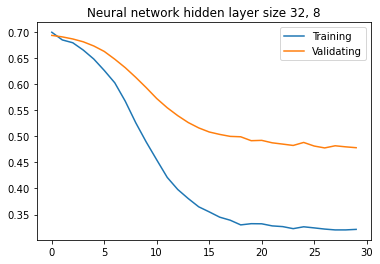

In [586]:
#plot the loss history
plt.plot(train_losses, label = 'Training')
plt.plot(val_losses, label = "Validating")
plt.title("Neural network hidden layer size 32, 8")
plt.legend()
plt.savefig('learning.pdf')

In [582]:
# calculate f-1 score
predictions = np.argmax(net(torch.Tensor(testing_features)).detach().numpy(),axis = 1)
f1_score(testing_labels, predictions, average='macro')

0.8778539194384087